# Generación de Texto / RNN - LSTM

# 1 Carga de Datos

In [ ]:
# Instalamos Keras y Tensorflow

install.packages("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’




In [ ]:
# Cargamos las liberías a utilizar

library(keras)
library(readr)
library(stringr)

In [ ]:
# Cargamos el texto y lo convertimos a minúsculas

texto <- read_file("/content/sample_data/jackandjill.txt") %>%
  str_to_lower()
texto

[1] "jack and jill went up the hill\nto fetch a pail of water\njack fell down and broke his crown\nand jill came tumbling after\n\njack got up and home did trot\nas fast as he could caper\nhe went to bed to mend his head\nwith vinegar and brown paper\n\njack and jill went up the hill\nto fetch a pail of water\njack fell down and broke his crown\nand jill came tumbling after\n\njack got up and home did trot\nas fast as he could caper\nhe went to bed to mend his head\nwith vinegar and brown paper\n\njack and jill went up the hill\nto fetch a pail of water\njack fell down and broke his crown\nand jill came tumbling after\n\njack got up and home did trot\nas fast as he could caper\nhe went to bed to mend his head\nwith vinegar and brown paper\n"

# 2 Preparación de los Datos

In [ ]:
# Codificamos el número de palabras más frecuentes

tokenizer <- text_tokenizer(num_words = 35)
tokenizer %>%
  fit_text_tokenizer(texto)

cat("Palabras únicas:", length(tokenizer$word_index)) # vocabulario
head(tokenizer$word_index)

Palabras únicas: 37

$and
[1] 1

$jack
[1] 2

$to
[1] 3

$jill
[1] 4

$went
[1] 5

$up
[1] 6

In [ ]:
# Convertimos los caracteres únicos a números enteros

enteros <- texts_to_sequences(tokenizer, texto)
enteros

[[1]]
  [1]  2  1  4  5  6 10 11  3 12 13 14 15 16  2 17 18  1 19  7 20  1  4 21 22 23
 [26]  2 24  6  1 25 26 27  8 28  8  9 29 30  9  5  3 31  3 32  7 33 34  1  2  1
 [51]  4  5  6 10 11  3 12 13 14 15 16  2 17 18  1 19  7 20  1  4 21 22 23  2 24
 [76]  6  1 25 26 27  8 28  8  9 29 30  9  5  3 31  3 32  7 33 34  1  2  1  4  5
[101]  6 10 11  3 12 13 14 15 16  2 17 18  1 19  7 20  1  4 21 22 23  2 24  6  1
[126] 25 26 27  8 28  8  9 29 30  9  5  3 31  3 32  7 33 34  1

In [ ]:
# Resumimos los datos

n_caracteres <- enteros[[1]]
cat("Caracteres en el texto:", length(n_caracteres))

Caracteres en el texto: 144

In [ ]:
# Creamos secuencias de la misma longitud

secuencia <- 2
X_train <- matrix(ncol = secuencia)
y_train <- matrix(ncol = 1)
for (i in seq(secuencia, length(n_caracteres))){
  if (i >= length(n_caracteres))
    break()
  inicio_indice <- (i - secuencia) + 1
  fin_indice <- i + 1
  nueva_secuencia <- n_caracteres[inicio_indice:fin_indice]
  X_train <- rbind(X_train, nueva_secuencia[1 : secuencia])
  y_train <- rbind(y_train, nueva_secuencia[secuencia + 1])
}

head(X_train)

NA,NA
2,1
1,4
4,5
5,6
6,10


In [ ]:
X_train <- X_train[-1, ]
y_train <- y_train[-1, ]
head(X_train)

2,1
1,4
4,5
5,6
6,10
10,11


In [ ]:
# Codificamos la variable de salida "y"

y_train <- to_categorical(y_train, num_classes = tokenizer$num_words)

# 3 Modelado de la Red

In [ ]:
# Definimos el modelo LSTM

model <- keras_model_sequential() %>%
  layer_embedding(input_dim = tokenizer$num_words,
                  output_dim = 10,
                  input_length = secuencia) %>% # 1 capa embedding (entrada secuencia de enteros)
  layer_lstm(units = 50) %>% # 1 capa LSTM
  layer_dense(units = tokenizer$num_words,
              activation = "softmax") # 1 capa densa

In [ ]:
# Obtenemos un resumen del modelo

summary(model)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 embedding_1 (Embedding)            (None, 2, 10)                   350         
 lstm_1 (LSTM)                      (None, 50)                      12200       
 dense_1 (Dense)                    (None, 35)                      1785        
Total params: 14,335
Trainable params: 14,335
Non-trainable params: 0
________________________________________________________________________________


In [ ]:
# Definimos algunos parámetros

#epocas <- 20
lr <- 0.001
#decay <- lr/epocas
rmsprop <- optimizer_rmsprop(learning_rate = lr)

In [ ]:
# Entrenamos el modelo

model %>% compile(optimizer = rmsprop,
                  loss = "categorical_crossentropy",
                  metrics = c("accuracy"))

In [ ]:
# Ajustamos el modelo

history <- model %>% fit(X_train, y_train,
                          epochs = 200)

history


Final epoch (plot to see history):
    loss: 0.02951
accuracy: 0.9789 

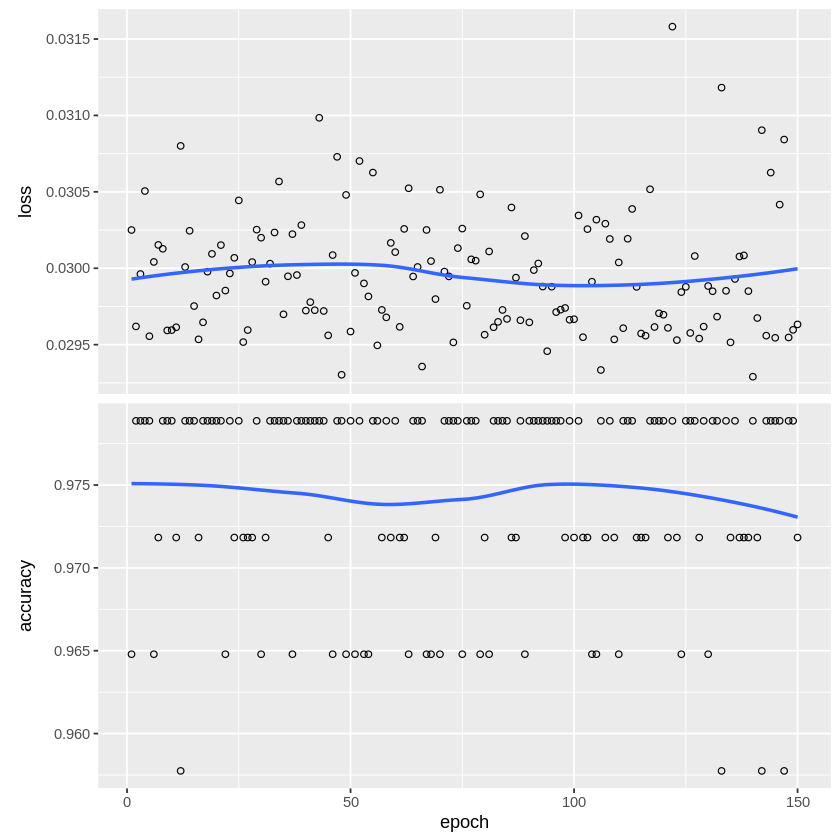

In [ ]:
plot(history)

# 4 Generación de Texto

In [ ]:
# Generamos texto

generador <- function(model, tokenizer, secuencia, semilla, n_predicciones){
  texto_entrada <- semilla
  for(i in seq(n_predicciones)){
    codificador <- texts_to_sequences(tokenizer, texto_entrada)[[1]]
    codificador <- pad_sequences(sequences = list(codificador),
                                  maxlen = secuencia,
                                  padding = "pre")
    y_pred <- predict(model, codificador) %>% k_argmax()
    next_word <- tokenizer$index_word[[as.character(as.array(y_pred))]]
    texto_entrada <- paste(texto_entrada, next_word)
  }
  return(texto_entrada)
}

In [ ]:
# Elegimos una semilla

semilla1 <- "Jack and"
cat("Texto generado con la semilla:",
    generador(model =  model, tokenizer = tokenizer,
              secuencia = secuencia, semilla =  semilla1,
              n_predicciones = 11), "\n")

Texto generado con la semilla: Jack and jill came tumbling after jack got up and home did trot 


In [ ]:
# Elegimos una semilla

semilla2 <- "Jack fell"
cat("Texto generado con la semilla:",
    generador(model =  model, tokenizer = tokenizer,
              secuencia = secuencia, semilla =  semilla2,
              n_predicciones = 11), "\n")

Texto generado con la semilla: Jack fell down and broke his crown and jill came tumbling after jack 
